In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import zipfile
import seaborn as sns
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report

# set seed to reproduce similar results
np.random.seed(0)

In [2]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + './human+activity+recognition+using+smartphones/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + './human+activity+recognition+using+smartphones/UCI HAR Dataset/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

In [3]:
trainX, trainy, testX, testy = load_dataset()

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


In [4]:
# Helper function to plot distribution of the features
def plot_distributions(trainX):
	# remove overlap
	cut = int(trainX.shape[1] / 2)
	longX = trainX[:, -cut:, :]
	# flatten windows
	longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
	print(longX.shape)
	pyplot.figure()
	xaxis = None
	for i in range(longX.shape[1]):
		ax = pyplot.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
		ax.set_xlim(-1, 1)
		if i == 0:
			xaxis = ax
		pyplot.hist(longX[:, i], bins=100)
	pyplot.show()

(470528, 9)


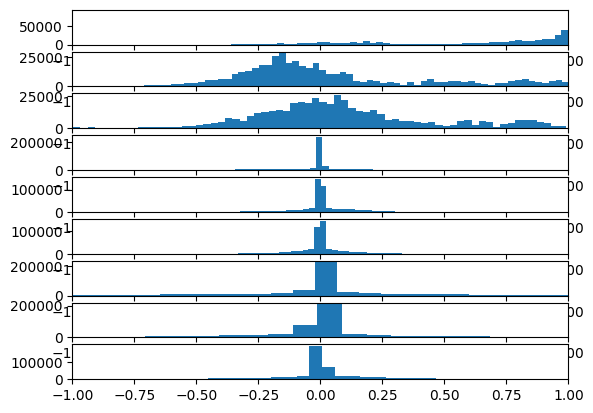

In [5]:
# plot distributions
plot_distributions(trainX)

In [6]:
## set number of epochs and batch size
batch_size = 64
validation_split = 0.2
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

In [7]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
classNames=["WALKING","WALKING_UPSTAIRS","WALKING_DOWNSTAIRS","SITTING","STANDING","LAYING"]

In [8]:
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense


model1 = Sequential()

# Bidirectional LSTM 레이어
model1.add(Bidirectional(LSTM(100, input_shape=(n_timesteps,n_features))))
model1.add(Dropout(0.5))
model1.add(Dense(100, activation='relu'))

# 출력 Dense 레이어
model1.add(Dense(n_outputs, activation='softmax'))

# 모델 컴파일
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# fit network
train_epochs = 10
history1 = model1.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/10
92/92 [==============================] - 50s 451ms/step - loss: 1.1543 - accuracy: 0.5115 - val_loss: 0.9170 - val_accuracy: 0.6118
Epoch 2/10
92/92 [==============================] - 40s 432ms/step - loss: 0.7318 - accuracy: 0.6791 - val_loss: 0.7390 - val_accuracy: 0.7090
Epoch 3/10
92/92 [==============================] - 41s 443ms/step - loss: 0.5267 - accuracy: 0.7839 - val_loss: 0.6846 - val_accuracy: 0.7893
Epoch 4/10
92/92 [==============================] - 40s 433ms/step - loss: 0.3653 - accuracy: 0.8692 - val_loss: 0.5608 - val_accuracy: 0.8817
Epoch 5/10
92/92 [==============================] - 38s 408ms/step - loss: 0.4951 - accuracy: 0.8381 - val_loss: 0.6947 - val_accuracy: 0.7729
Epoch 6/10
92/92 [==============================] - 38s 413ms/step - loss: 0.3573 - accuracy: 0.8796 - val_loss: 0.3659 - val_accuracy: 0.8885
Epoch 7/10
92/92 [==============================] - 38s 409ms/step - loss: 0.2015 - accuracy: 0.9281 - val_loss: 0.4134 - val_accuracy: 0.8960

In [10]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 200)              88000     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 100)               20100     
                                                                 
 dense_1 (Dense)             (None, 6)                 606       
                                                                 
Total params: 108,706
Trainable params: 108,706
Non-trainable params: 0
_________________________________________________________________


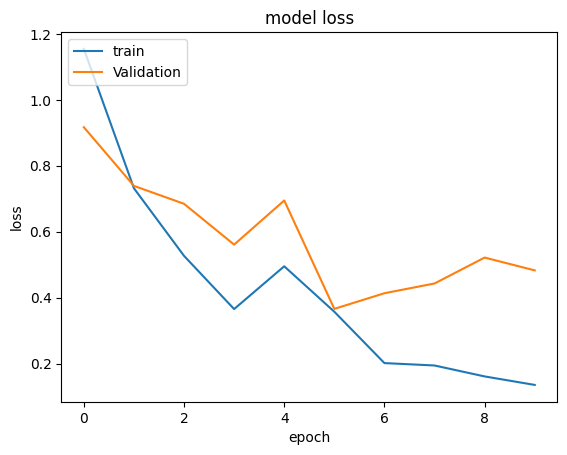

In [11]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [12]:
# evaluate model
test_loss, test_accuracy = model1.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the BiLSTM model", test_accuracy)
predictions=model1.predict(testX)

Accuracy of the BiLSTM model 0.8842890858650208
93/93 [==============================] - 5s 36ms/step


**** Confusion Matrix ****


[[443   5  47   1   0   0]
 [  1 432  38   0   0   0]
 [  0   4 416   0   0   0]
 [  4   2   0 416  64   5]
 [  7   2   0 120 403   0]
 [  0  41   0   0   0 496]]
**** Classification Report ****
                    precision    recall  f1-score   support

           WALKING       0.97      0.89      0.93       496
  WALKING_UPSTAIRS       0.89      0.92      0.90       471
WALKING_DOWNSTAIRS       0.83      0.99      0.90       420
           SITTING       0.77      0.85      0.81       491
          STANDING       0.86      0.76      0.81       532
            LAYING       0.99      0.92      0.96       537

          accuracy                           0.88      2947
         macro avg       0.89      0.89      0.88      2947
      weighted avg       0.89      0.88      0.88      2947



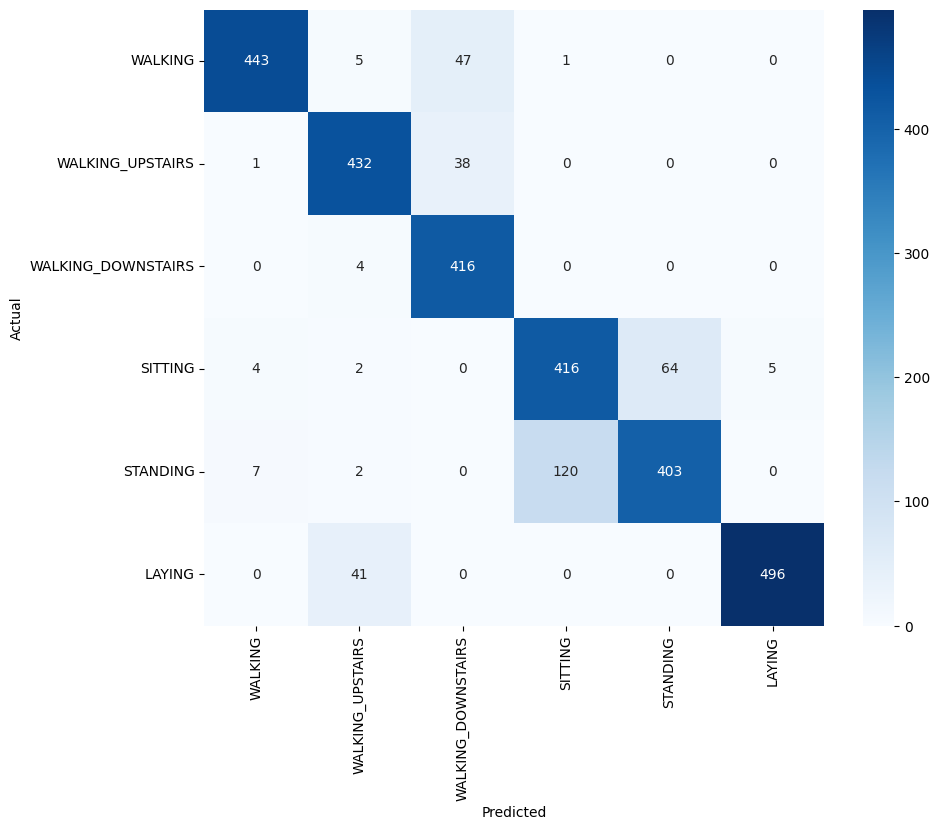

In [13]:
display_results(testy,predictions,classNames)

In [14]:
from keras.layers import GRU

# 모델 초기화
model2 = Sequential()

# GRU 레이어
model2.add(GRU(100, input_shape=(n_timesteps, n_features)))

# 다른 GRU 레이어나 레이어 추가 가능
model2.add(Dense(100, activation='relu'))

# 출력 Dense 레이어
model2.add(Dense(n_outputs, activation='softmax'))

# 모델 컴파일
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
# fit network
train_epochs = 10
history2 = model2.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/10
92/92 [==============================] - 19s 160ms/step - loss: 1.1933 - accuracy: 0.5331 - val_loss: 1.0173 - val_accuracy: 0.6302
Epoch 2/10
92/92 [==============================] - 13s 146ms/step - loss: 0.8101 - accuracy: 0.6594 - val_loss: 0.7227 - val_accuracy: 0.7152
Epoch 3/10
92/92 [==============================] - 15s 160ms/step - loss: 0.5104 - accuracy: 0.7886 - val_loss: 0.5797 - val_accuracy: 0.8484
Epoch 4/10
92/92 [==============================] - 13s 145ms/step - loss: 0.2963 - accuracy: 0.8976 - val_loss: 0.3877 - val_accuracy: 0.8906
Epoch 5/10
92/92 [==============================] - 13s 146ms/step - loss: 0.1985 - accuracy: 0.9279 - val_loss: 0.3924 - val_accuracy: 0.8661
Epoch 6/10
92/92 [==============================] - 13s 145ms/step - loss: 0.1815 - accuracy: 0.9296 - val_loss: 0.2575 - val_accuracy: 0.9041
Epoch 7/10
92/92 [==============================] - 14s 148ms/step - loss: 0.1412 - accuracy: 0.9464 - val_loss: 0.2751 - val_accuracy: 0.9096

In [16]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100)               33300     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 6)                 606       
                                                                 
Total params: 44,006
Trainable params: 44,006
Non-trainable params: 0
_________________________________________________________________


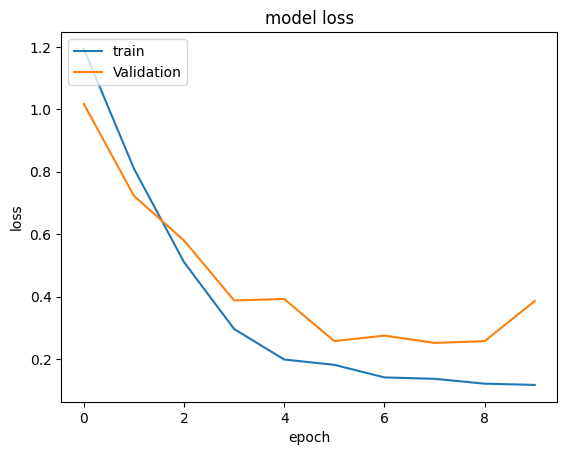

In [17]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [18]:
# evaluate model
test_loss, test_accuracy = model2.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the GRU model", test_accuracy)
predictions=model2.predict(testX)

Accuracy of the GRU model 0.9026128053665161
93/93 [==============================] - 3s 25ms/step


**** Confusion Matrix ****
[[474   4  18   0   0   0]
 [ 15 422  28   4   2   0]
 [  2   4 414   0   0   0]
 [  0   1   2 360 128   0]
 [  8   0   0  44 480   0]
 [  0  27   0   0   0 510]]
**** Classification Report ****
                    precision    recall  f1-score   support

           WALKING       0.95      0.96      0.95       496
  WALKING_UPSTAIRS       0.92      0.90      0.91       471
WALKING_DOWNSTAIRS       0.90      0.99      0.94       420
           SITTING       0.88      0.73      0.80       491
          STANDING       0.79      0.90      0.84       532
            LAYING       1.00      0.95      0.97       537

          accuracy                           0.90      2947
         macro avg       0.91      0.90      0.90      2947
      weighted avg       0.91      0.90      0.90      2947



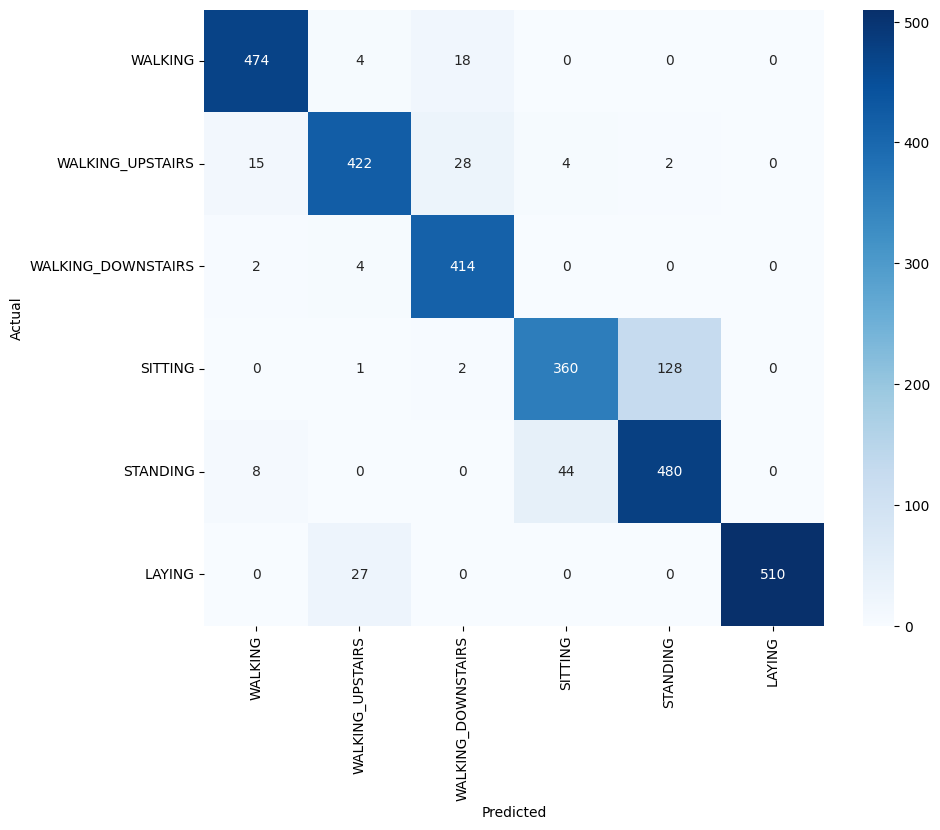

In [19]:
display_results(testy, predictions, classNames)

In [20]:
from keras.layers import TimeDistributed
# 모델 초기화
model3 = Sequential()

# Bidirectional GRU 레이어
model3.add(Bidirectional(GRU(100, input_shape=(n_timesteps, n_features))))

# 다른 GRU 레이어나 레이어 추가 가능
# model3.add(GRU(50, input_shape=(n_timesteps, n_features)))
model3.add(Dense(100, activation='relu'))

# 출력 Dense 레이어
model3.add((Dense(n_outputs, activation='softmax')))

# 모델 컴파일
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
# fit network
train_epochs = 10
history3 = model3.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/10
92/92 [==============================] - 39s 340ms/step - loss: 1.0817 - accuracy: 0.5681 - val_loss: 0.9876 - val_accuracy: 0.5908
Epoch 2/10
92/92 [==============================] - 26s 284ms/step - loss: 0.6117 - accuracy: 0.7540 - val_loss: 0.5681 - val_accuracy: 0.7988
Epoch 3/10
92/92 [==============================] - 28s 307ms/step - loss: 0.3908 - accuracy: 0.8495 - val_loss: 0.3855 - val_accuracy: 0.8640
Epoch 4/10
92/92 [==============================] - 28s 304ms/step - loss: 0.2354 - accuracy: 0.9145 - val_loss: 0.3117 - val_accuracy: 0.8933
Epoch 5/10
92/92 [==============================] - 28s 303ms/step - loss: 0.1675 - accuracy: 0.9347 - val_loss: 0.2614 - val_accuracy: 0.9048
Epoch 6/10
92/92 [==============================] - 29s 315ms/step - loss: 0.1478 - accuracy: 0.9393 - val_loss: 0.2246 - val_accuracy: 0.9123
Epoch 7/10
92/92 [==============================] - 29s 312ms/step - loss: 0.1266 - accuracy: 0.9476 - val_loss: 0.2866 - val_accuracy: 0.9035

In [22]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 200)              66600     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 6)                 606       
                                                                 
Total params: 87,306
Trainable params: 87,306
Non-trainable params: 0
_________________________________________________________________


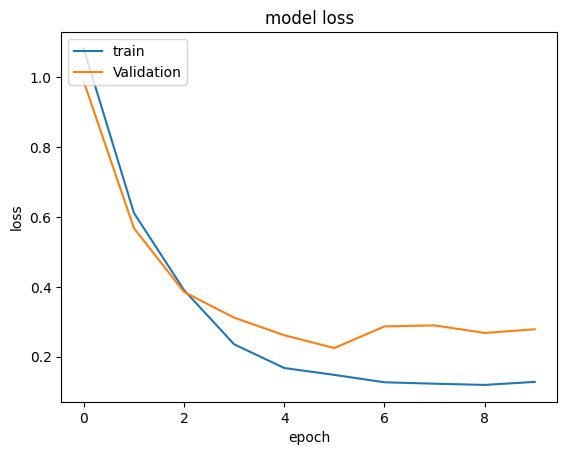

In [23]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [24]:
# evaluate model
test_loss, test_accuracy = model3.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the BiGRU model", test_accuracy)
predictions=model3.predict(testX)

Accuracy of the BiGRU model 0.8873430490493774
93/93 [==============================] - 4s 30ms/step


**** Confusion Matrix ****
[[458  10  26   1   1   0]
 [ 20 421  30   0   0   0]
 [  7   1 412   0   0   0]
 [  0  26   0 328 137   0]
 [  7   2   0  37 486   0]
 [  0  27   0   0   0 510]]
**** Classification Report ****
                    precision    recall  f1-score   support

           WALKING       0.93      0.92      0.93       496
  WALKING_UPSTAIRS       0.86      0.89      0.88       471
WALKING_DOWNSTAIRS       0.88      0.98      0.93       420
           SITTING       0.90      0.67      0.77       491
          STANDING       0.78      0.91      0.84       532
            LAYING       1.00      0.95      0.97       537

          accuracy                           0.89      2947
         macro avg       0.89      0.89      0.89      2947
      weighted avg       0.89      0.89      0.89      2947



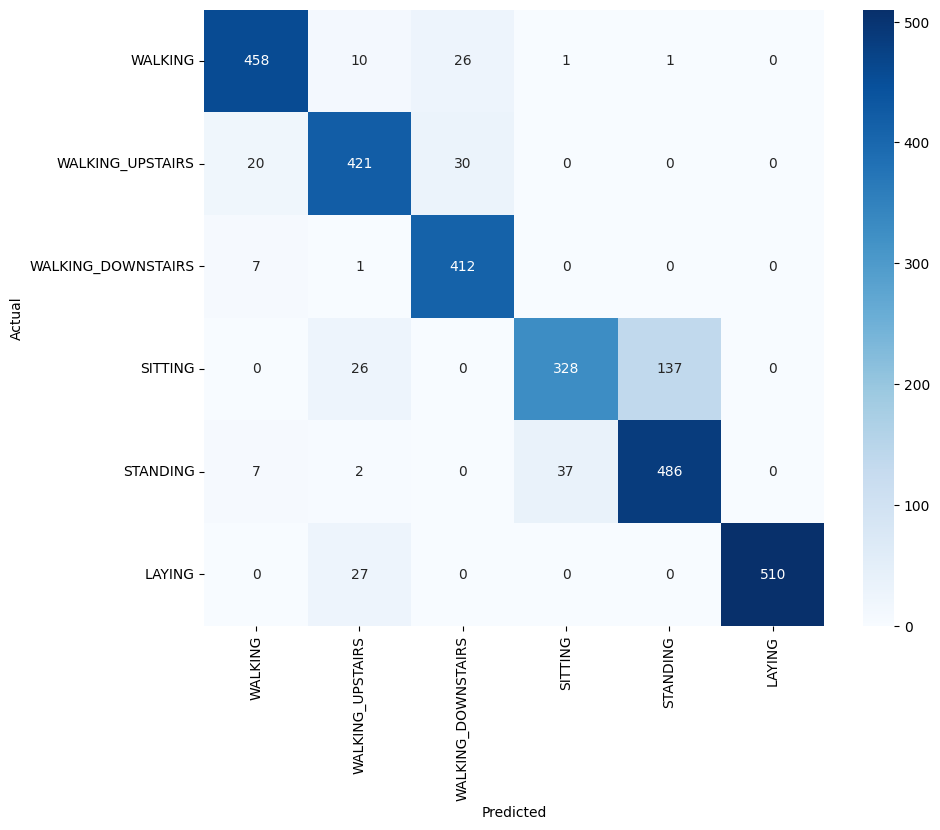

In [25]:
display_results(testy, predictions, classNames)